<a href="https://colab.research.google.com/github/ghadfield32/Zero_to_Mastery_Learn_PyTorch_for_Deep_Learning/blob/main/06_transferlearn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

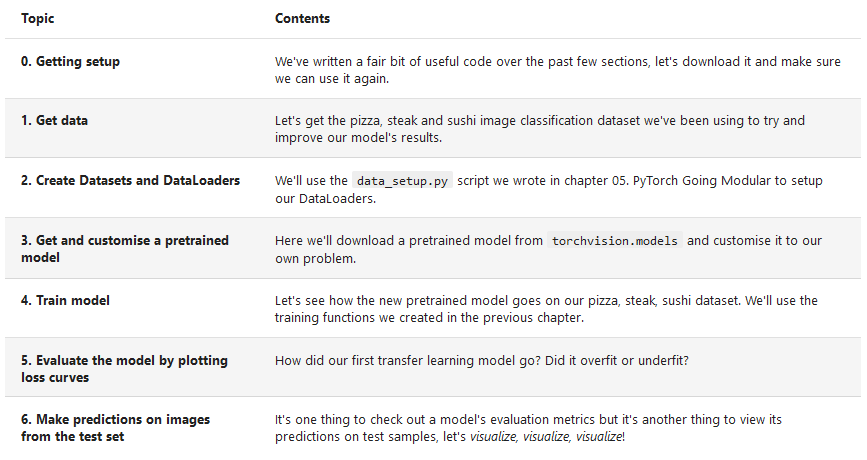

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [142]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine, data_setup2
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/ghadfield32/Zero_to_Mastery_Learn_PyTorch_for_Deep_Learning.git
    !mv Zero_to_Mastery_Learn_PyTorch_for_Deep_Learning/going_modular .
    !rm -rf Zero_to_Mastery_Learn_PyTorch_for_Deep_Learning
    from going_modular import data_setup, engine, data_setup2


In [143]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [144]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [145]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [146]:
#Different model's

# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)


# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
efficientnet_b1_weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
# Get the transforms used to create our pretrained weights, print weights or auto transforms for a better look
efficientnet_b1_auto_transforms = efficientnet_b1_weights.transforms()
#create model from pretrained best available weights
efficientnet_b1_model = torchvision.models.efficientnet_b1(weights=efficientnet_b1_weights).to(device)


#model # uncomment to output (it's very long)

Vision Transformer (ViT)

Vision Transformer (ViT) is a model that applies the transformer architecture, primarily used for NLP tasks, to image classification. Unlike CNNs, ViT treats image classification as a sequence prediction problem.

* ViT-B/16: This variant of ViT splits an image into fixed-size patches, linearly embeds each of them, and then processes them with a standard transformer encoder. "B/16" denotes the base model size with 16x16 pixel patches.

In [147]:
vit_b_16_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_b_16_auto_tranforms = vit_b_16_weights
vit_b_16_model = torchvision.models.vit_b_16(weights=vit_b_16_weights).to(device)
#print(vit_b_16_model)


ConvNeXt

ConvNeXt models are a recent development in the field of CNNs, inspired by the design principles of Vision Transformers. They adopt a similar architecture to transformers but operate in the CNN paradigm.

* ConvNeXt-Tiny: This is a smaller variant of the ConvNeXt models, designed to balance performance and computational efficiency. It's particularly notable for its transformer-like architecture but in a CNN context.

In [148]:
convnext_weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
convnext_auto_transforms = convnext_weights.transforms()
convnext_model = torchvision.models.convnext_tiny(weights=convnext_weights).to(device)
#print(convnext_model)

ResNet

ResNet, short for Residual Networks, is a classic neural network used in computer vision. The key innovation in ResNet is the introduction of "skip connections" or "shortcuts" to jump over some layers, which helps solve the vanishing gradient problem and allows the network to be much deeper.

* ResNet50: This variant has 50 layers and is a good balance between depth, complexity, and performance. It's widely used for many image classification tasks.

In [149]:

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
resnet50_weights = torchvision.models.ResNet50_Weights.DEFAULT
# Get the transforms used to create our pretrained weights, print weights or auto transforms for a better look
resnet50_auto_transforms = resnet50_weights.transforms()
#create model from pretrained best available weights
resnet50_model = torchvision.models.resnet50(weights=resnet50_weights).to(device)

VGG

VGG, developed by Visual Graphics Group at Oxford, was one of the first breakthroughs in deep learning for image recognition. The main characteristic of VGG is its simplicity, using only 3x3 convolutional layers stacked on top of each other in increasing depth.

* VGG16: It has 16 layers that have weights (13 convolutional and 3 fully connected layers). It's known for its simplicity and depth.
* VGG16 is quite large and has a significant number of parameters, making it computationally intensive.

In [150]:
vgg16_weights = torchvision.models.VGG16_Weights.DEFAULT
vgg16_auto_transforms = vgg16_weights.transforms()
vgg16_model = torchvision.models.vgg16(weights=vgg16_weights).to(device)



3.3 Getting a summary of our model with torchinfo.summary()

To learn more about our model, let's use torchinfo's summary() method.

To do so, we'll pass in:

    model - the model we'd like to get a summary of.
    input_size - the shape of the data we'd like to pass to our model, for the case of efficientnet_b0, the input size is (batch_size, 3, 224, 224), though other variants of efficientnet_bX have different input sizes.
        Note: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d(), this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to summary() or your models.
    col_names - the various information columns we'd like to see about our model.
    col_width - how wide the columns should be for the summary.
    row_settings - what features to show in a row.



EfficientNet is a group of convolutional neural network (CNN) models designed with efficiency in mind. The key innovation in EfficientNet is the use of a compound scaling method, where the depth, width, and resolution of the network are scaled in a balanced manner. This allows for much better efficiency (lower FLOPs) for a given level of accuracy compared to other models.

    EfficientNet-B0 to B7: The series starts from B0 (the baseline model) to B7, with each subsequent model being slightly larger and more accurate than the previous one.
    EfficientNet-B1: This variant is just a bit larger than B0, offering a balance between speed and accuracy.

In [151]:
#Model integration
#efficientnet_b1
model = efficientnet_b1_model
#print(model)
#changeable final layer:
#(classifier): Sequential(
#    (0): Dropout(p=0.2, inplace=True)
#    (1): Linear(in_features=1280, out_features=1000, bias=True)
auto_transforms = efficientnet_b1_auto_transforms

#
model = vgg16_model
print(model)
#changeable final layer:
#Sequential(
#    (0): Linear(in_features=25088, out_features=4096, bias=True)
#    (1): ReLU(inplace=True)
#    (2): Dropout(p=0.5, inplace=False)
#    (3): Linear(in_features=4096, out_features=4096, bias=True)
#    (4): ReLU(inplace=True)
#    (5): Dropout(p=0.5, inplace=False)
#    (6): Linear(in_features=4096, out_features=1000, bias=True)
auto_transforms = vgg16_auto_transforms

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [152]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79f202130160>,
 ['pizza', 'steak', 'sushi'])

In [153]:
#try self automated transformation "create_dataloaders" from data_setup2
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup2.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               #transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79f1c619bcd0>,
 ['pizza', 'steak', 'sushi'])

In [154]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

For reference, our model from previous sections, TinyVGG had 8,083 parameters vs. 5,288,548 parameters for efficientnet_b0, an increase of ~654x!


3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.
changing the efficientnet classifier head to a custom number of outputs

You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original torchvision.models.efficientnet_b0() comes with out_features=1000 because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need out_features=3.

Let's freeze all of the layers/parameters in the features section of our efficientnet_b0 model.

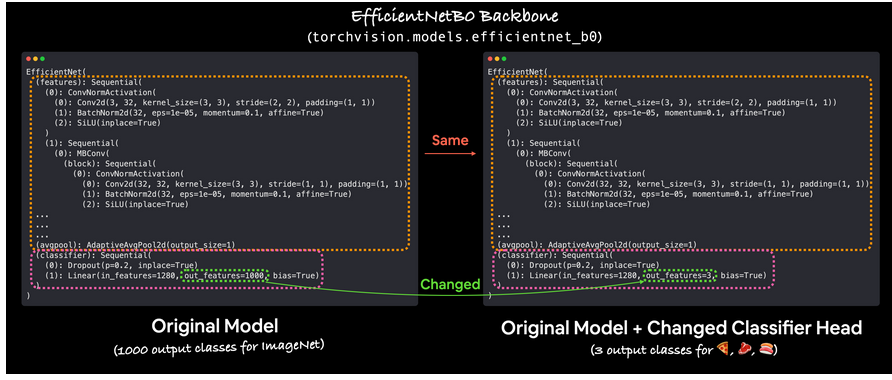

In [155]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [164]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
3#printed layer to recreate from model:   (classifier): Sequential(
#    (0): Dropout(p=0.2, inplace=True)
#    (1): Linear(in_features=1280, out_features=3, bias=True)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

#my own layer change: vgg16_model - INSANE results > Overfitting good so check on that but it's predicting right on custom images!!
#Sequential(
#    (0): Linear(in_features=25088, out_features=4096, bias=True)
#    (1): ReLU(inplace=True)
#    (2): Dropout(p=0.5, inplace=False)
#    (3): Linear(in_features=4096, out_features=4096, bias=True)
#    (4): ReLU(inplace=True)
#    (5): Dropout(p=0.5, inplace=False)
#    (6): Linear(in_features=4096, out_features=1000, bias=True)

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True), #True
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True), #True
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(in_features=4096,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [165]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [166]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [167]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 12.9221 | train_acc: 0.4766 | test_loss: 0.5097 | test_acc: 0.7604
Epoch: 2 | train_loss: 0.3450 | train_acc: 0.8516 | test_loss: 0.3871 | test_acc: 0.8049
Epoch: 3 | train_loss: 0.0572 | train_acc: 0.9805 | test_loss: 0.6121 | test_acc: 0.7642
Epoch: 4 | train_loss: 0.0025 | train_acc: 1.0000 | test_loss: 0.4763 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.0023 | train_acc: 1.0000 | test_loss: 0.8089 | test_acc: 0.8466
[INFO] Total training time: 16.155 seconds


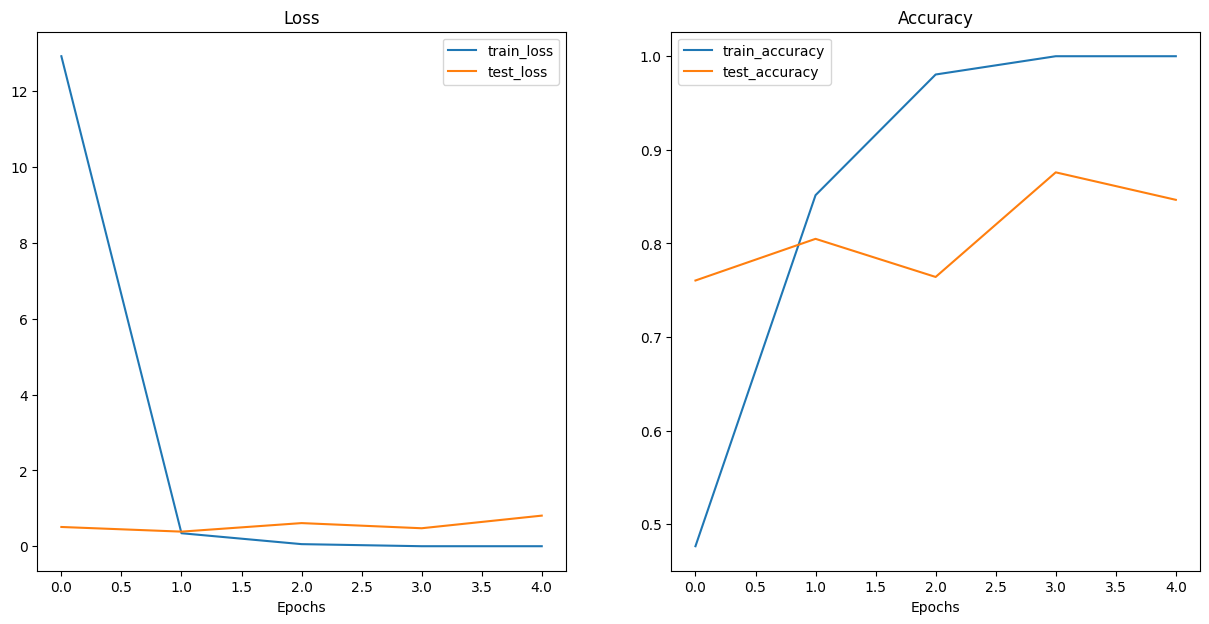

In [168]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [169]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

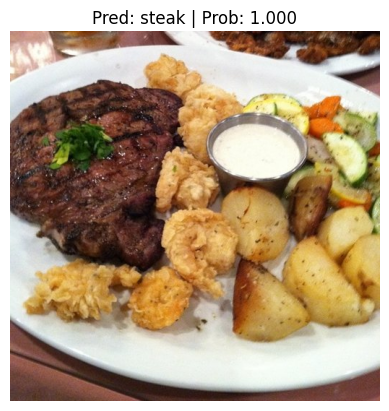

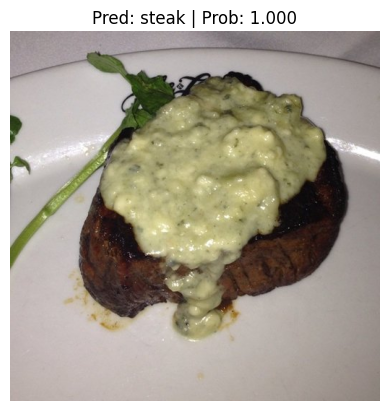

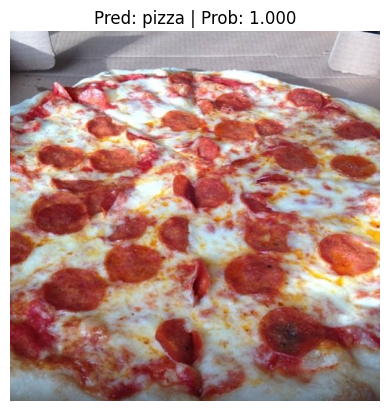

In [170]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

data/04-pizza-dad.jpeg already exists, skipping download.


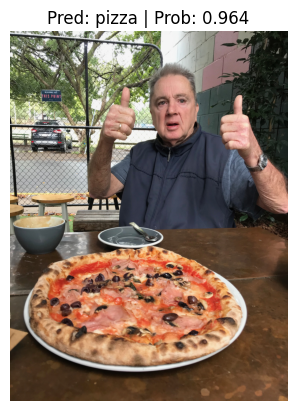

In [171]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)